In [10]:
import os
import json
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

CONFIG = {
    "IMG_SIZE": 512,          
    "LATENT_DIM": 64,         
    "BATCH_SIZE": 32,          
    "TEACHER_EPOCHS": 20,     
    "STUDENT_EPOCHS": 50,     
    "LR": 1e-4,               
    "SHAPE_LAMBDA": 2.0,      # measures how much to listen to the Shape Guardrail vs Pixel Loss
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "JSON_PATH": "./arcade/syntax/train/annotations/train.json", 
    "IMG_DIR": "./arcade/syntax/train/images"        
}

print(f"Running on: {CONFIG['DEVICE']}")

class ArcadeDataset(Dataset):
    def __init__(self, images_dir, json_file, img_size=512):
        self.images_dir = images_dir
        self.img_size = img_size
        
        try:
            with open(json_file, 'r') as f:
                self.coco_data = json.load(f)
        except FileNotFoundError:
            print(f"Error: Could not find {json_file}. Please check path.")
            self.coco_data = {'images': [], 'annotations': []}

        self.img_id_to_ann = {}
        for ann in self.coco_data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.img_id_to_ann:
                self.img_id_to_ann[img_id] = []
            self.img_id_to_ann[img_id].append(ann)
            
        self.images_info = self.coco_data['images']

    def __len__(self):
        return len(self.images_info)

    def __getitem__(self, idx):
        img_info = self.images_info[idx]
        file_name = img_info['file_name']
        img_path = os.path.join(self.images_dir, file_name)
        
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            image = np.zeros((self.img_size, self.img_size), dtype=np.uint8)
            
        h, w = image.shape
        
        mask = np.zeros((h, w), dtype=np.uint8)
        anns = self.img_id_to_ann.get(img_info['id'], [])
        
        for ann in anns:
            if 'segmentation' in ann:
                for poly in ann['segmentation']:
                    poly_arr = np.array(poly).reshape((-1, 2)).astype(np.int32)
                    cv2.fillPoly(mask, [poly_arr], 1)

        image_t = torch.from_numpy(image).float().unsqueeze(0) / 255.0
        mask_t = torch.from_numpy(mask).float().unsqueeze(0)
        
        image_t = TF.resize(image_t, [self.img_size, self.img_size], interpolation=TF.InterpolationMode.BILINEAR)
        mask_t = TF.resize(mask_t, [self.img_size, self.img_size], interpolation=TF.InterpolationMode.NEAREST)

        return image_t, mask_t

class ShapeAutoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(ShapeAutoencoder, self).__init__()
        
        # Encoder: 512 -> 256 -> 128 -> 64 -> 32
        self.encoder_net = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(),
        )
        
        self.flatten_dim = 128 * (CONFIG['IMG_SIZE'] // 16) * (CONFIG['IMG_SIZE'] // 16)
        
        self.fc_enc = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, self.flatten_dim)
        
        self.decoder_net = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder_net(x)
        x = x.view(x.size(0), -1)
        z = self.fc_enc(x)
        return z

    def forward(self, x):
        z = self.encode(x)
        x_rec = self.fc_dec(z)
        x_rec = x_rec.view(x_rec.size(0), 128, CONFIG['IMG_SIZE']//16, CONFIG['IMG_SIZE']//16)
        x_rec = self.decoder_net(x_rec)
        return x_rec, z
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(),
            nn.Conv2d(out_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c)
        )
        self.skip = nn.Sequential()
        if in_c != out_c:
            self.skip = nn.Conv2d(in_c, out_c, 1) # Adjust dimensions
            
    def forward(self, x):
        return torch.relu(self.conv(x) + self.skip(x))

class StudentSegmentor(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.e1 = ResidualBlock(1, 32)
        self.pool = nn.MaxPool2d(2)
        self.e2 = ResidualBlock(32, 64)
        self.e3 = ResidualBlock(64, 128)
        
        # Bottleneck
        self.b = ResidualBlock(128, 256)
        
        # Decoder
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.d3 = ResidualBlock(256 + 128, 128) 
        self.d2 = ResidualBlock(128 + 64, 64)
        self.d1 = ResidualBlock(64 + 32, 32)
        
        self.final = nn.Conv2d(32, 1, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        x1 = self.e1(x)
        p1 = self.pool(x1)
        x2 = self.e2(p1)
        p2 = self.pool(x2)
        x3 = self.e3(p2)
        p3 = self.pool(x3)
        
        b = self.b(p3)
        
        # Decoder with Skip Connections (U-Net style flow)
        d3 = self.d3(torch.cat([self.up(b), x3], dim=1))
        d2 = self.d2(torch.cat([self.up(d3), x2], dim=1))
        d1 = self.d1(torch.cat([self.up(d2), x1], dim=1))
        
        return self.sigmoid(self.final(d1))


def train_teacher(teacher, dataloader):
    print("\n--- PHASE 1: Training Shape Teacher (Autoencoder) ---")
    optimizer = optim.Adam(teacher.parameters(), lr=CONFIG['LR'])
    criterion = nn.MSELoss()
    
    teacher.train()
    for epoch in range(CONFIG['TEACHER_EPOCHS']):
        total_loss = 0
        for _, masks in dataloader: # Ignore images, only use masks
            masks = masks.to(CONFIG['DEVICE'])
            
            optimizer.zero_grad()
            reconstruction, _ = teacher(masks)
            loss = criterion(reconstruction, masks)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        print(f"Teacher Epoch {epoch+1}/{CONFIG['TEACHER_EPOCHS']} | Loss: {total_loss/len(dataloader):.5f}")

    torch.save(teacher.state_dict(), "shape_teacher.pth")
    print("Teacher saved.")

def train_student(student, teacher, dataloader):
    print("\n--- PHASE 2: Training Student with INITIAL Logic & High Shape Lambda ---")
    
    # Freeze Teacher
    teacher.eval()
    for param in teacher.parameters():
        param.requires_grad = False
        
    optimizer = optim.Adam(student.parameters(), lr=CONFIG['LR'])
    
    # BACK TO BASICS: Standard Binary Cross Entropy
    # (No manual weights, no Dice loss yet)
    pixel_criterion = nn.BCELoss() 
    shape_criterion = nn.MSELoss()
    
    # THE ONLY CHANGE: 10x stronger Shape Guardrail
    # Old value was 0.5. New value is 5.0.
    # This forces the model to prioritize "Valid Tube Shape" over "Perfect Pixel Accuracy"
    NEW_SHAPE_LAMBDA = 5.0 
    
    student.train()
    for epoch in range(CONFIG['STUDENT_EPOCHS']):
        total_loss = 0
        
        for images, masks in dataloader:
            images = images.to(CONFIG['DEVICE'])
            masks = masks.to(CONFIG['DEVICE'])
            
            optimizer.zero_grad()
            
            # 1. Student predicts mask
            pred_masks = student(images)
            
            # 2. Standard Pixel Loss (The one that worked before)
            loss_pixel = pixel_criterion(pred_masks, masks)
            
            # 3. Shape Guardrail Loss
            with torch.no_grad():
                gt_latent = teacher.encode(masks)
            
            pred_latent = teacher.encode(pred_masks)
            loss_shape = shape_criterion(pred_latent, gt_latent)
            
            # Combine
            loss = loss_pixel + (NEW_SHAPE_LAMBDA * loss_shape)
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        print(f"Student Epoch {epoch+1}/{CONFIG['STUDENT_EPOCHS']} | Total Loss: {total_loss/len(dataloader):.5f}")

    torch.save(student.state_dict(), "arcade_student_model_lambda5.pth")
    print("Student saved.")
if __name__ == "__main__":

    if os.path.exists(CONFIG['JSON_PATH']):
        dataset = ArcadeDataset(CONFIG['IMG_DIR'], CONFIG['JSON_PATH'], CONFIG['IMG_SIZE'])
        # In your main execution block
        dataloader = DataLoader(
            dataset,          
            shuffle=True, 
            num_workers=10,          
            pin_memory=True,        
            persistent_workers=True 
        )
        
        teacher_model = ShapeAutoencoder(latent_dim=CONFIG['LATENT_DIM']).to(CONFIG['DEVICE'])
        student_model = StudentSegmentor().to(CONFIG['DEVICE'])
        
        train_teacher(teacher_model, dataloader)
        
        train_student(student_model, teacher_model, dataloader)
        
        print("\nTraining Complete. Models saved to disk.")
    else:
        print("Dataset not found. Please set 'JSON_PATH' and 'IMG_DIR' in the CONFIG dictionary.")

Running on: cuda

--- PHASE 1: Training Shape Teacher (Autoencoder) ---
Teacher Epoch 1/20 | Loss: 0.07782
Teacher Epoch 2/20 | Loss: 0.03476
Teacher Epoch 3/20 | Loss: 0.02725
Teacher Epoch 4/20 | Loss: 0.02350
Teacher Epoch 5/20 | Loss: 0.02115
Teacher Epoch 6/20 | Loss: 0.01963
Teacher Epoch 7/20 | Loss: 0.01788
Teacher Epoch 8/20 | Loss: 0.01645
Teacher Epoch 9/20 | Loss: 0.01515
Teacher Epoch 10/20 | Loss: 0.01392
Teacher Epoch 11/20 | Loss: 0.01285
Teacher Epoch 12/20 | Loss: 0.01185
Teacher Epoch 13/20 | Loss: 0.01100
Teacher Epoch 14/20 | Loss: 0.01027
Teacher Epoch 15/20 | Loss: 0.00957
Teacher Epoch 16/20 | Loss: 0.00898
Teacher Epoch 17/20 | Loss: 0.00848
Teacher Epoch 18/20 | Loss: 0.00803
Teacher Epoch 19/20 | Loss: 0.00765
Teacher Epoch 20/20 | Loss: 0.00730
Teacher saved.

--- PHASE 2: Training Student with INITIAL Logic & High Shape Lambda ---
Student Epoch 1/50 | Total Loss: 184925.09578
Student Epoch 2/50 | Total Loss: 84984.96756
Student Epoch 3/50 | Total Loss: 7400

In [1]:
!pwd
!ls

/workspace/Bioml
Untitled1.ipynb  arcade  arcade_student_model.pth  shape_teacher.pth


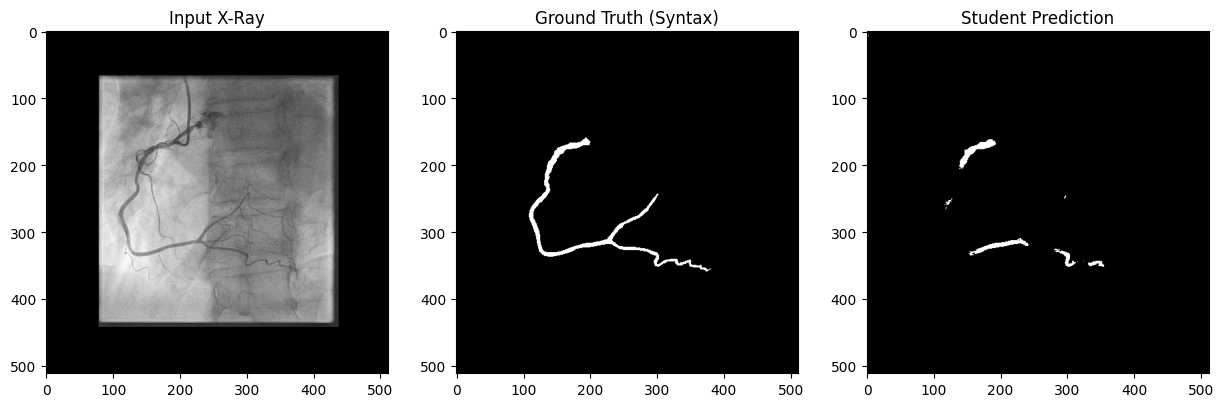

In [12]:
import matplotlib.pyplot as plt
import torch

def visualize_prdiction(model, dataset, device="cuda"):
    model.eval()
    
    idx = 5  
    image, gt_mask = dataset[idx]
    
    input_tensor = image.unsqueeze(0).to(device) # Add batch dim
    with torch.no_grad():
        pred_mask = model(input_tensor)
    
    pred_mask = pred_mask.squeeze().cpu().numpy()
    gt_mask = gt_mask.squeeze().cpu().numpy()
    
    pred_binary = (pred_mask > 0.5).astype(float)
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image.squeeze(), cmap="gray")
    ax[0].set_title("Input X-Ray")
    
    ax[1].imshow(gt_mask, cmap="gray")
    ax[1].set_title("Ground Truth (Syntax)")
    
    ax[2].imshow(pred_binary, cmap="gray")
    ax[2].set_title("Student Prediction")
    
    plt.show()

visualize_prdiction(student_model, dataset)

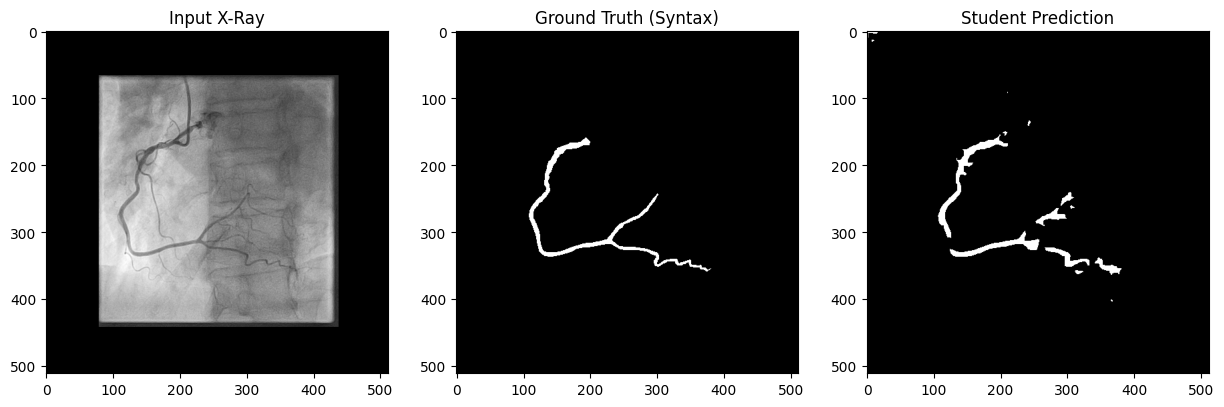

In [14]:
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np

def visualize_prediction(model, dataset, device="cuda"):
    model.eval()
    
    idx = 5  
    image, gt_mask = dataset[idx]
    
    input_tensor = image.unsqueeze(0).to(device) \
    with torch.no_grad():
        pred_mask = model(input_tensor)
    
    pred_mask = pred_mask.squeeze().cpu().numpy()
    gt_mask = gt_mask.squeeze().cpu().numpy()
    
    pred_binary = (pred_mask > 0.07).astype(np.uint8)
    kernel = np.ones((5,5), np.uint8)
    pred_connected = cv2.morphologyEx(pred_binary, cv2.MORPH_CLOSE, kernel)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image.squeeze(), cmap="gray")
    ax[0].set_title("Input X-Ray")
    
    ax[1].imshow(gt_mask, cmap="gray")
    ax[1].set_title("Ground Truth (Syntax)")
        
    ax[2].imshow(pred_connected, cmap="gray")
    ax[2].set_title("Student Prediction")
    
    plt.show()
    
visualize_prediction(student_model, dataset)

In [7]:
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np

def visualize_prediction(model, dataset, device="cuda"):
    model.eval()
    
    idx = 5  
    image, gt_mask = dataset[idx]
    
    input_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        pred_mask = model(input_tensor)
    
    pred_mask = pred_mask.squeeze().cpu().numpy()
    gt_mask = gt_mask.squeeze().cpu().numpy()
    
    pred_binary = (pred_mask > 0.01).astype(np.uint8)
    kernel = np.ones((5,5), np.uint8)
    pred_connected = cv2.morphologyEx(pred_binary, cv2.MORPH_CLOSE, kernel)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image.squeeze(), cmap="gray")
    ax[0].set_title("Input X-Ray")
    
    ax[1].imshow(gt_mask, cmap="gray")
    ax[1].set_title("Ground Truth (Syntax)")
        
    ax[2].imshow(pred_connected, cmap="gray")
    ax[2].set_title("Student Prediction")
    
    plt.show()
s_model = torch.load("./arcade_student_model_v2.pth",map_location=torch.device('cuda'))
s_model.load_state_dict(s_model)
visualize_prediction(s_model, dataset)

AttributeError: 'collections.OrderedDict' object has no attribute 'load_state_dict'